In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings('ignore')

In [23]:
# Load the dataset
hcho_data = pd.read_csv('preprocessed_dataset/hcho_data.csv')
hcho_data.head()

,HCHO Reading,Location,Current Date,Next Date
0,0.000197,Colombo Proper,2019-01-01,2019-01-02
1,0.000197,"Deniyaya, Matara",2019-01-01,2019-01-02
2,0.000263,Nuwara Eliya Proper,2019-01-01,2019-01-02
3,0.000263,Colombo Proper,2019-01-02,2019-01-03
4,0.000006,"Deniyaya, Matara",2019-01-02,2019-01-03


In [24]:
# Perform the Augmented Dickey-Fuller test
adf_test = adfuller(hcho_data['HCHO Reading'])

print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])
print('Critical Values:')
for key, value in adf_test[4].items():
    print('\t%s: %.3f' % (key, value))

# Based on the p-value, decide on stationarity
if adf_test[1] > 0.05:
    print("The series is likely non-stationary and may need differencing.")
else:
    print("The series is likely stationary.")

ADF Statistic: -11.491048
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
The series is likely stationary.


In [25]:
# Convert 'Current Date' to datetime and set as index
hcho_data['Current Date'] = pd.to_datetime(hcho_data['Current Date'])
hcho_data.set_index('Current Date', inplace=True)

# Output the first few rows and the index to verify changes
hcho_data_after = hcho_data.head()
hcho_data_info = hcho_data.index

hcho_data_after

,HCHO Reading,Location,Next Date
Current Date,,,
2019-01-01,0.000197,Colombo Proper,2019-01-02
2019-01-01,0.000197,"Deniyaya, Matara",2019-01-02
2019-01-01,0.000263,Nuwara Eliya Proper,2019-01-02
2019-01-02,0.000263,Colombo Proper,2019-01-03
2019-01-02,0.000006,"Deniyaya, Matara",2019-01-03


In [26]:
hcho_data.tail(10)

,HCHO Reading,Location,Next Date
Current Date,,,
2023-12-29,0.000051,"Bibile, Monaragala",2023-12-30
2023-12-29,0.000127,Kurunegala Proper,2023-12-30
2023-12-29,0.000127,Jaffna Proper,2023-12-30
2023-12-30,0.000127,"Bibile, Monaragala",2023-12-31
2023-12-30,0.000158,Kurunegala Proper,2023-12-31
2023-12-30,0.000117,Jaffna Proper,2023-12-31
2023-12-31,0.000117,"Bibile, Monaragala",2024-01-01
2023-12-31,0.000065,Kurunegala Proper,2024-01-01
2023-12-31,0.000065,Jaffna Proper,2024-01-01


In [27]:
hcho_data_info

DatetimeIndex(['2019-01-01', '2019-01-01', '2019-01-01', '2019-01-02',
               '2019-01-02', '2019-01-02', '2019-01-03', '2019-01-03',
               '2019-01-03', '2019-01-04',
               ...
               '2023-12-29', '2023-12-29', '2023-12-29', '2023-12-30',
               '2023-12-30', '2023-12-30', '2023-12-31', '2023-12-31',
               '2023-12-31', '2023-01-24'],
              dtype='datetime64[ns]', name='Current Date', length=12782, freq=None)

In [28]:
# Running ADF test on the 'HCHO Reading' of one of the locations
result = adfuller(hcho_data[hcho_data['Location'] == 'Colombo Proper']['HCHO Reading'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -4.636878169720643
p-value: 0.00011039390127992954


In [29]:
# Selecting the data for the model
colombo_data = hcho_data[hcho_data['Location'] == 'Colombo Proper']['HCHO Reading']
colombo_data

Current Date
2019-01-01    0.000197
2019-01-02    0.000263
2019-01-03    0.000099
2019-01-04    0.000210
2019-01-05    0.000179
                ...   
2023-12-28    0.000228
2023-12-29    0.000140
2023-12-30    0.000140
2023-12-31    0.000080
2022-03-07    0.000254
Name: HCHO Reading, Length: 1826, dtype: float64

In [30]:
# Fit the ARIMA model
arima_model = ARIMA(colombo_data, order=(1, 0, 1))
arima_result = arima_model.fit()

# Print out the summary of the model
model_summary = arima_result.summary()

# Display the model summary
model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           HCHO Reading   No. Observations:                 1826
Model:                 ARIMA(1, 0, 1)   Log Likelihood               14384.871
Date:                Wed, 17 Apr 2024   AIC                         -28761.742
Time:                        00:13:37   BIC                         -28739.703
Sample:                             0   HQIC                        -28753.612
                               - 1826                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001   6.61e-06     21.619      0.000       0.000       0.000
ar.L1          0.8675   2.56e-10   3.39e+09      0.000       0.868       0.868
ma.L1         -0.5930   1.06e-10  -5.61e+09      0.000      -0.593      -0.593
sigma2      8.411e-09   2.23e-10     37.637      0.000    7.97e-09    8.85e-09
===================================================================================
Ljung-Box (L1) (Q):                   1.04   Jarque-Bera (JB):               143.73
Prob(Q):                              0.31   Prob(JB):                         0.00
Heteroskedasticity (H):               0.89   Skew:                             0.17
Prob(H) (two-sided):                  0.15   Kurtosis:                         4.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.54e+26. Standard errors may be unstable.
"""

In [31]:
# Assuming colombo_data has a DateTime index
last_index = colombo_data.index[-2]
new_index = pd.date_range(start=last_index, periods=31, freq='D')[1:]  # 'M' for monthly, adjust as needed

# Forecast with the new index
forecast = arima_result.forecast(steps=30, index=new_index)

# Display the forecast
forecast

2024-01-01    0.000166
2024-01-02    0.000163
2024-01-03    0.000161
2024-01-04    0.000158
2024-01-05    0.000156
2024-01-06    0.000154
2024-01-07    0.000153
2024-01-08    0.000152
2024-01-09    0.000150
2024-01-10    0.000149
2024-01-11    0.000149
2024-01-12    0.000148
2024-01-13    0.000147
2024-01-14    0.000147
2024-01-15    0.000146
2024-01-16    0.000146
2024-01-17    0.000145
2024-01-18    0.000145
2024-01-19    0.000145
2024-01-20    0.000145
2024-01-21    0.000144
2024-01-22    0.000144
2024-01-23    0.000144
2024-01-24    0.000144
2024-01-25    0.000144
2024-01-26    0.000144
2024-01-27    0.000144
2024-01-28    0.000143
2024-01-29    0.000143
2024-01-30    0.000143
Freq: D, Name: predicted_mean, dtype: float64

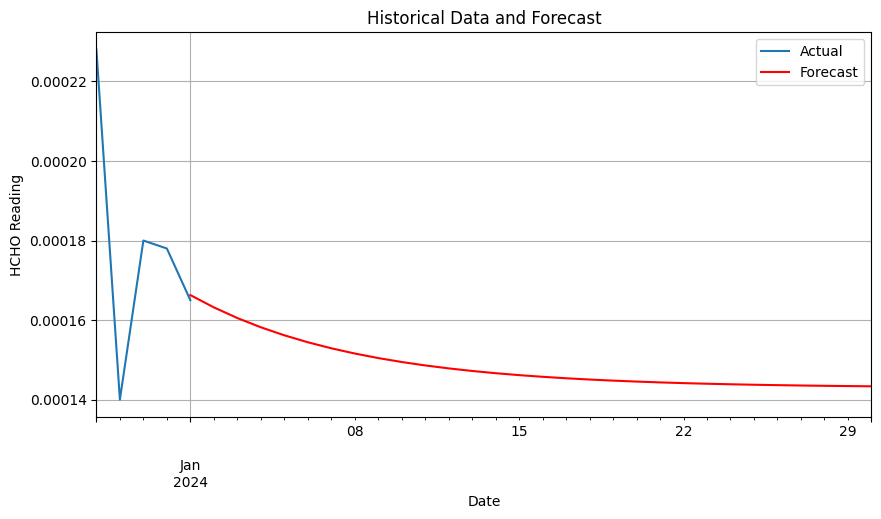

In [44]:
colombo_data = pd.DataFrame({'HCHO Reading': [0.000228, 0.000140, 0.000180, 0.000178, 0.000165]},
                      index=pd.date_range('2023-12-28', periods=5, freq='D'))

# Plotting
plt.figure(figsize=(10, 5))
colombo_data['HCHO Reading'].plot(label='Actual')
forecast.plot(color='red', label='Forecast')
plt.title('Historical Data and Forecast')
plt.xlabel('Date')
plt.ylabel('HCHO Reading')
plt.legend()
plt.grid(True)
plt.show()